**In this Notebook we will use a Tagged Twitter CSV file to train and save a RNN in order to use it in our covid-vaccine dataset for our sentiment analysis**

# Importing Libraries

In [ ]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Load Dataset

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO/view?usp=sharing' #the shareable link


In [ ]:
 id = '1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO'

print (id) # Verify that you have everything after '='

1Auz_mQrYW9YEpdQflVHpCGW1BZAs6VYO


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training.1600000.processed.noemoticon.csv')  
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [ ]:
data = data.sample(frac=1)
data = data[:200000]

# Data Visualization 

Dataset details target: the polarity of the tweet (0 = negative, 4 = positive)

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [ ]:
data

,polarity,id,date,query,user,text
1594060,4,2192063726,Tue Jun 16 06:26:51 PDT 2009,NO_QUERY,RachelEJonas,"LINES, VINES, AND TRYING TIMES...in stores NOW..."
392297,0,2055115752,Sat Jun 06 08:43:39 PDT 2009,NO_QUERY,Miriam1216,I give up! No eye liner or mascara it just won...
245225,0,1981956002,Sun May 31 10:14:00 PDT 2009,NO_QUERY,lisacwil,How can I clean up if LINGO is on
160907,0,1957171202,Thu May 28 23:43:08 PDT 2009,NO_QUERY,eckodabrat,@Deziree_Divine take my advice lookin through ...
225969,0,1977752894,Sat May 30 21:37:58 PDT 2009,NO_QUERY,RocKo808,"Went 2 gamestop, ran into co-worker who i used..."
...,...,...,...,...,...,...
1162484,4,1979592184,Sun May 31 03:42:40 PDT 2009,NO_QUERY,dheaasa,really really likes Obama
669457,0,2246263331,Fri Jun 19 17:20:06 PDT 2009,NO_QUERY,SophieBxoxo,is hoping manchester united do well next seaso...
832686,4,1557632741,Sun Apr 19 05:13:50 PDT 2009,NO_QUERY,AllieG,@theuedimaster I wouldn't miss it.
1119372,4,1973759559,Sat May 30 11:46:45 PDT 2009,NO_QUERY,alittlevoice,"@nisha is here and we have a party to go to, d..."


In [ ]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
1594060,1,2192063726,Tue Jun 16 06:26:51 PDT 2009,NO_QUERY,RachelEJonas,"LINES, VINES, AND TRYING TIMES...in stores NOW..."
392297,0,2055115752,Sat Jun 06 08:43:39 PDT 2009,NO_QUERY,Miriam1216,I give up! No eye liner or mascara it just won...
245225,0,1981956002,Sun May 31 10:14:00 PDT 2009,NO_QUERY,lisacwil,How can I clean up if LINGO is on
160907,0,1957171202,Thu May 28 23:43:08 PDT 2009,NO_QUERY,eckodabrat,@Deziree_Divine take my advice lookin through ...
225969,0,1977752894,Sat May 30 21:37:58 PDT 2009,NO_QUERY,RocKo808,"Went 2 gamestop, ran into co-worker who i used..."


In [ ]:
#Some metric statistics of our dataset
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.501205,1.999259e+09
std,0.500000,1.931408e+08
min,0.000000,1.467811e+09
25%,0.000000,1.956954e+09
50%,1.000000,2.002195e+09
75%,1.000000,2.177037e+09
max,1.000000,2.329205e+09


In [ ]:

# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))



Total length of the data is:         200000
No. of positve tagged sentences is:  100241
No. of negative tagged sentences is: 99759


# Data Proccessing

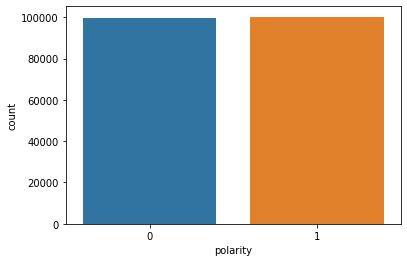

In [ ]:
%matplotlib inline
sns.countplot(data['polarity'])

In [ ]:

# Removing the unnecessary columns.
data.drop(['date','query','user'], axis=1, inplace=True)


In [ ]:
data.drop('id', axis=1, inplace=True)


In [ ]:
data.head()

,polarity,text
1594060,1,"LINES, VINES, AND TRYING TIMES...in stores NOW..."
392297,0,I give up! No eye liner or mascara it just won...
245225,0,How can I clean up if LINGO is on
160907,0,@Deziree_Divine take my advice lookin through ...
225969,0,"Went 2 gamestop, ran into co-worker who i used..."


In [ ]:

#converting pandas object to a string type
data['text'] = data['text'].astype('str')



In [ ]:
#load stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
exclude_words = set(("hasn", "couldn", "weren", "wasn", "not", "doesn", "shouldn", "isn","didn", "haven", "aren", "needn", "nor", "aren't", "mightn't", "hasn't","wasn't", "couldn't","wouldn","won't","doesn't","don't","didn't","mightn","isn't")) 
stopword = stop_word.difference(exclude_words)

print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'if', 'me', 'doing', 'about', 'there', 'your', 'be', 'down', "that'll", 'who', 'am', 'through', 'were', 'too', 'o', 'won', 'having', 'some', 'most', 'on', 'their', 'whom', 'these', 'm', 'the', 'been', 'herself', 'had', 'any', "you're", 'it', "you'll", 'below', 'from', 'no', 'our', "she's", 'i', 'against', 'an', 'do', 'in', 'at', 'than', 'she', 'and', 'then', 'but', 'which', 'to', "weren't", 'ours', 'theirs', 'as', 'will', 'was', 'same', 'he', 'again', 'its', 'between', "should've", 'both', 'after', 'other', 'yourself', 'all', 'why', 'd', 've', "shan't", 'a', 'have', 'over', 'under', 'itself', 'll', 'up', 'such', 'until', 'ma', 'we', 'where', 'of', 'now', 'by', 'before', 'or', 's', 'this', 'yourselves', "wouldn't", "needn't", 'once', 'does', 'here', 'further', 'is', 'shan', 'so', 'while', 'you', 'because', 'are', "haven't", 'when', 'myself', 'off', 'can', 'being', 'his

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Now some textcleaning Preproccessing**

In [ ]:

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtag = '#[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
  
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    # Remove hashtag #
    tweet = re.sub(hashtag,'',tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)



In [ ]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
data.head(50)

,polarity,text,processed_tweets
1594060,1,"LINES, VINES, AND TRYING TIMES...in stores NOW...",line vine trying timesin store go pick amazing
392297,0,I give up! No eye liner or mascara it just won...,give eye liner mascara wont cooperate today
245225,0,How can I clean up if LINGO is on,clean lingo
160907,0,@Deziree_Divine take my advice lookin through ...,take advice lookin phone cost relationship
225969,0,"Went 2 gamestop, ran into co-worker who i used...",went gamestop ran coworker used like im sad
308153,0,X-Plane iPhone Racing: F-15 - Canyons - Near m...,xplane iphone racing f15 canyon near midair fl...
1375327,1,@Alyssa_Milano do celebs get more characters t...,celebs get character rest u
984549,1,Cooking for dinner Japanese food today : P,cooking dinner japanese food today
517646,0,@Jamesdc09 I screwed up. BAAAD.,screwed baaad
406627,0,Wow! Not having a date to a wedding where you ...,wow not date wedding barely know anyone suck


# Vectorization and Splitting Data

In [ ]:

X = data['processed_tweets'].values
y = data['polarity'].values



In [ ]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


**Convert text to word frequency vectors**

In [ ]:

#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))



Vector fitted.
No. of feature_words:  99663


In [ ]:
print(X.shape)
print(y.shape)

(200000, 99663)
(200000,)


**Split and Train Test**



The Preprocessed Data is divided into 2 sets of data:


*   Training Data: The dataset upon which the model would be trained on. Contains 80% data.
*  Test Data: The dataset upon which the model would be tested against. Contains 20% data.








In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 99663)
y_train (160000,)

X_test (40000, 99663)
y_test (40000,)


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Accuracy of model on training data : 81.959375
Accuracy of model on testing data : 77.425 

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     20024
           1       0.76      0.80      0.78     19976

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



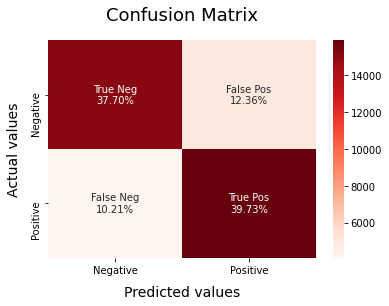

In [ ]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

# RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
import keras

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    7  622  155]
 [   0    0    0 ...  326  110   12]
 [   0    0    0 ...    0    0  570]
 ...
 [   0    0    0 ...    0  532   33]
 [   0    0    0 ...  266   96   65]
 [   0    0    0 ... 2033  431  786]]


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(Bidirectional(layers.LSTM(64,dropout=0.5)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
5000/5000 [==============================] - 1214s 242ms/step - loss: 0.5311 - accuracy: 0.7290 - val_loss: 0.4658 - val_accuracy: 0.7780

Epoch 00001: val_accuracy improved from -inf to 0.77798, saving model to rnn_model.hdf5
Epoch 2/5
5000/5000 [==============================] - 1227s 245ms/step - loss: 0.4517 - accuracy: 0.7875 - val_loss: 0.4585 - val_accuracy: 0.7833

Epoch 00002: val_accuracy improved from 0.77798 to 0.78328, saving model to rnn_model.hdf5
Epoch 3/5
5000/5000 [==============================] - 1227s 245ms/step - loss: 0.4292 - accuracy: 0.7981 - val_loss: 0.4615 - val_accuracy: 0.7830

Epoch 00003: val_accuracy did not improve from 0.78328
Epoch 4/5
5000/5000 [==============================] - 1213s 243ms/step - loss: 0.4153 - accuracy: 0.8083 - val_loss: 0.4717 - val_accuracy: 0.7828

Epoch 00004: val_accuracy did not improve from 0.78328
Epoch 5/5
5000/5000 [==============================] - 1221s 244ms/step - loss: 0.3978 - accuracy: 0.8166 - val_los

In [ ]:
sequence = tokenizer.texts_to_sequences(["I am  healthy"])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

print(pred)

Positive
[[0.89564276]]


In [ ]:
model = tf.keras.models.load_model('rnn_model.hdf5')


In [ ]:
sequence = tokenizer.texts_to_sequences(["I like the vaccines but i do not trust the companies"])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

print(pred)

Negative
[[0.3405847]]


In [ ]:
!mkdir -p saved_model
model.save('saved_model/biderectional_model.hdf5') 

In [ ]:
!ls saved_model

rnn_model.hdf5


# Loading our covid vaccine dataset

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link1 = 'https://drive.google.com/file/d/102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy/view?usp=sharing' #the shareable link

In [ ]:
id = '102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy'

print (id) # Verify that you have everything after '='

102uB9cfp5ul3bc9WZZJ-A8MbsP1HAySy


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tweets_loc.csv')  
df3 = pd.read_csv('tweets_loc.csv')
df3

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
0,1,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405.0,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,folk said daikon paste could treat cytokine st...,0.292167,Negative,-118.231705,34.219170
1,2,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834.0,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,world wrong side history year hopefully bigges...,0.753310,Positive,-122.727652,37.785063
2,3,1.337858e+18,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10.0,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,0.364838,Negative,-2.942752,42.685166
3,4,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165.0,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,fact immutable senator even youre not ethicall...,0.187278,Negative,-123.124101,49.257308
4,5,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152.0,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,explain need vaccine whereareallthesickpeople ...,0.782983,Positive,12.502155,13.187038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69718,69719,1.382248e+18,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862.0,589.0,3502.0,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2.0,9.0,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,0.408473,Negative,6.143047,46.204829
69719,69720,1.382246e+18,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164.0,101.0,6465.0,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0.0,0.0,False,sputnikv africanexpertise medical academic voi...,0.220360,Negative,28.855412,-27.228607
69720,69721,1.382245e+18,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76.0,65.0,78.0,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0.0,0.0,False,hello stubbornness foolishness facing second w...,0.952513,Positive,12.502155,13.187038
69721,69722,1.382243e+18,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882.0,1850.0,83008.0,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0.0,0.0,False,lengthy interview wato month ago representativ...,0.782384,Positive,0.126595,52.197586


In [ ]:
df3['text'][10]

'while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP'


**Pre-processing text data**

Most of the text data are cleaned by following below steps.
*   *Remove punctuations*
*   *Tokenization - Converting a sentence into list of words* 
*   *Remove stopwords* 
*   *Lammetization/stemming - Tranforming any form of a word to its root word*





  

  




# Pre-Proccess for our prediction Model

In [ ]:
#converting pandas object to a string type
df3['text'] = df3['text'].astype('str')

In [ ]:
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
exclude_words = set(("hasn", "couldn", "weren", "wasn", "not", "doesn", "shouldn", "isn","didn", "haven", "aren", "needn", "nor", "")) 
stopword = stop_word.difference(exclude_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtag = '#[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    tweet = re.sub(hashtag,'', tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
df3['processed_tweets'] = df3['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

LookupError: ignored

In [ ]:
df3.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,folk said daikon paste could treat cytokine storm
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,world wrong side history year hopefully bigges...
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,russian vaccine created last 24 years…
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,fact immutable senator even youre not ethicall...
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,explain need vaccine
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False,anyone useful adviceguidance whether covid vac...
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,bit sad claim fame success patriotic competiti...
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,not many bright day 2020 best winning
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False,covid vaccine getting
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,state start getting monday say


# Pre - Proccess for future use

In [ ]:
#clean text

#create a function to clean tweets

def cleanTxt(text):
  
  text = re.sub(r'@[A-Za-z0-9]+', '', text)# Removed @a Mentions
  text = re.sub(r'RT[\s]+', '', text) #Removing RT
  text = re.sub('\s+', ' ', text)  # Remove new line characters
  text = re.sub(r'https?://\S+|www\.\S+', '', text)#Remove hyperlink
  text = re.sub('[0-9]+', '', text)
  text = re.sub("\'|\#|\`", "", text) # Remove distracting single quotes
  text = re.sub('\S*@\S*\s?', '', text) # Remove Emails
  


  string.punctuation
  text  = "".join([char for char in text if char not in string.punctuation])

  text= text.lower()

    
  return text

df3['Clean_text'] = df3['text'].apply(cleanTxt)

df3

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Clean_text
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,ame folk said daikon paste could treat cytokin...,same folks said daikon paste could treat a cyt...
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,hile world wrong side history year hopefully b...,while the world has been on the wrong side of ...
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,act immutable senator even youre not ethically...,facts are immutable senator even when youre no...
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,xplain need vaccine whereareallthesickpeople p...,explain to me again why we need a vaccine wher...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69713,1382248484259123205,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862,589,3502,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2,9,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,✅ 🇷🇺gamaleya research center in cooperation wi...
69714,1382246393532801026,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164,101,6465,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0,0,False,floydshivambu sputnikv africanexpertise medica...,sputnikv where are africanexpertise medical a...
69715,1382245076303179778,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76,65,78,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0,0,False,ello stubbornness foolishness facing second wa...,hello it s because of this stubbornness and fo...
69716,1382243373747146752,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882,1850,83008,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0,0,False,lengthy interview wato month ago representativ...,in a lengthy interview on wato some months ago...


**Tokenization**

In [ ]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df3['Tweet_tokenized'] = df3['Clean_text'].apply(lambda x: tokenization(x.lower()))
df3

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Clean_text,Tweet_tokenized
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,ame folk said daikon paste could treat cytokin...,same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea..."
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,hile world wrong side history year hopefully b...,while the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,..."
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,act immutable senator even youre not ethically...,facts are immutable senator even when youre no...,"[facts, are, immutable, senator, even, when, y..."
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,xplain need vaccine whereareallthesickpeople p...,explain to me again why we need a vaccine wher...,"[explain, to, me, again, why, we, need, a, vac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69713,1382248484259123205,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862,589,3502,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2,9,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,✅ 🇷🇺gamaleya research center in cooperation wi...,"[, gamaleya, research, center, in, cooperation..."
69714,1382246393532801026,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164,101,6465,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0,0,False,floydshivambu sputnikv africanexpertise medica...,sputnikv where are africanexpertise medical a...,"[, sputnikv, where, are, africanexpertise, med..."
69715,1382245076303179778,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76,65,78,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0,0,False,ello stubbornness foolishness facing second wa...,hello it s because of this stubbornness and fo...,"[hello, it, s, because, of, this, stubbornness..."
69716,1382243373747146752,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882,1850,83008,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0,0,False,lengthy interview wato month ago representativ...,in a lengthy interview on wato some months ago...,"[in, a, lengthy, interview, on, wato, some, mo..."


**Remove StopWords**

In [ ]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df3['Tweet_nonstop'] = df3['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df3.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Clean_text,Tweet_tokenized,Tweet_nonstop
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,ame folk said daikon paste could treat cytokin...,same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea...","[folks, said, daikon, paste, could, treat, cyt..."
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,hile world wrong side history year hopefully b...,while the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,...","[world, wrong, side, history, year, hopefully,..."
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,act immutable senator even youre not ethically...,facts are immutable senator even when youre no...,"[facts, are, immutable, senator, even, when, y...","[facts, immutable, senator, even, youre, not, ..."
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,xplain need vaccine whereareallthesickpeople p...,explain to me again why we need a vaccine wher...,"[explain, to, me, again, why, we, need, a, vac...","[explain, need, vaccine, whereareallthesickpeo..."
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False,oes anyone useful adviceguidance whether covid...,does anyone have any useful adviceguidance for...,"[does, anyone, have, any, useful, adviceguidan...","[anyone, useful, adviceguidance, whether, covi..."
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,bit sad claim fame success vaccination patriot...,it is a bit sad to claim the fame for success ...,"[it, is, a, bit, sad, to, claim, the, fame, fo...","[bit, sad, claim, fame, success, vaccination, ..."
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,not many bright day 2020 best bidenharris winn...,there have not been many bright days in but h...,"[there, have, not, been, many, bright, days, i...","[not, many, bright, days, best, bidenharris, w..."
8,1337850023531347969,Erin Despas,NaN,Designi

**Lemmatization**

In [ ]:
 nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df3['Tweet_lemma'] = df3['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
df3

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Clean_text,Tweet_tokenized,Tweet_nonstop,Tweet_lemma
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,ame folk said daikon paste could treat cytokin...,same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea...","[folks, said, daikon, paste, could, treat, cyt...","[folk, said, daikon, paste, could, treat, cyto..."
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,hile world wrong side history year hopefully b...,while the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,...","[world, wrong, side, history, year, hopefully,...","[world, wrong, side, history, year, hopefully,..."
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,act immutable senator even youre not ethically...,facts are immutable senator even when youre no...,"[facts, are, immutable, senator, even, when, y...","[facts, immutable, senator, even, youre, not, ...","[fact, immutable, senator, even, youre, not, e..."
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,xplain need vaccine whereareallthesickpeople p...,explain to me again why we need a vaccine wher...,"[explain, to, me, again, why, we, need, a, vac...","[explain, need, vaccine, whereareallthesickpeo...","[explain, need, vaccine, whereareallthesickpeo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69713,1382248484259123205,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862,589,3502,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2,9,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,✅ 🇷🇺gamaleya research center in cooperation wi...,"[, gamaleya, research, center, in, cooperation...","[, gamaleya, research, center, cooperation, sp...","[, gamaleya, research, center, cooperation, sp..."
69714,1382246393532801026,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164,101,6465,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0,0,False,floydshivambu sputnikv africanexpertise medica...,sputnikv where are africanexpertise medical a...,"[, sputnikv, where, are, africanexpertise, med...","[, sputnikv, africanexpertise, medical, academ...","[, sputnikv, africanexpertise, medical, academ..."
69715,1382245076303179778,Robert ka Boss,NaN,Lily don't 

# Perform Sentiment Analysis

In [ ]:
#converting pandas object to a string type
df3['processed_tweets'] = df3['processed_tweets'].astype('str')

In [ ]:
#Calculate the Polarities of our tweets
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(df3['processed_tweets'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)

pred



array([[0.7613121 ],
       [0.6413511 ],
       [0.57263434],
       ...,
       [0.9568589 ],
       [0.91565526],
       [0.90817606]], dtype=float32)

In [ ]:
pred.shape

(69723, 1)

In [ ]:

df3['Polarity'] = pred
df3

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
0,1,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405.0,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,folk said daikon paste could treat cytokine st...,0.761312,Negative,-118.231705,34.219170
1,2,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834.0,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,world wrong side history year hopefully bigges...,0.641351,Positive,-122.727652,37.785063
2,3,1.337858e+18,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10.0,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,0.572634,Negative,-2.942752,42.685166
3,4,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165.0,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,fact immutable senator even youre not ethicall...,0.499397,Negative,-123.124101,49.257308
4,5,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152.0,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,explain need vaccine whereareallthesickpeople ...,0.786513,Positive,12.502155,13.187038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69718,69719,1.382248e+18,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862.0,589.0,3502.0,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2.0,9.0,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,0.609648,Negative,6.143047,46.204829
69719,69720,1.382246e+18,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164.0,101.0,6465.0,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0.0,0.0,False,sputnikv africanexpertise medical academic voi...,0.502593,Negative,28.855412,-27.228607
69720,69721,1.382245e+18,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76.0,65.0,78.0,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0.0,0.0,False,hello stubbornness foolishness facing second w...,0.956859,Positive,12.502155,13.187038
69721,69722,1.382243e+18,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882.0,1850.0,83008.0,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0.0,0.0,False,lengthy interview wato month ago representativ...,0.915655,Positive,0.126595,52.197586


In [ ]:
#creat a function to compute the negative and positive analysis
def getAnalysis(score):
  if score < 0.5:
    return "Negative"
  else:
    return "Positive"

df3['Analysis']=df3['Polarity'].apply(getAnalysis)

df3 

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
0,1,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405.0,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,folk said daikon paste could treat cytokine st...,0.761312,Positive,-118.231705,34.219170
1,2,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834.0,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,world wrong side history year hopefully bigges...,0.641351,Positive,-122.727652,37.785063
2,3,1.337858e+18,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10.0,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,0.572634,Positive,-2.942752,42.685166
3,4,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165.0,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,fact immutable senator even youre not ethicall...,0.499397,Negative,-123.124101,49.257308
4,5,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152.0,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,explain need vaccine whereareallthesickpeople ...,0.786513,Positive,12.502155,13.187038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69718,69719,1.382248e+18,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862.0,589.0,3502.0,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2.0,9.0,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,0.609648,Positive,6.143047,46.204829
69719,69720,1.382246e+18,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164.0,101.0,6465.0,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0.0,0.0,False,sputnikv africanexpertise medical academic voi...,0.502593,Positive,28.855412,-27.228607
69720,69721,1.382245e+18,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76.0,65.0,78.0,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0.0,0.0,False,hello stubbornness foolishness facing second w...,0.956859,Positive,12.502155,13.187038
69721,69722,1.382243e+18,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882.0,1850.0,83008.0,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0.0,0.0,False,lengthy interview wato month ago representativ...,0.915655,Positive,0.126595,52.197586


In [ ]:
#Save the csv file for use in different notebooks
df3.to_csv(r'covid_vaccine_tagged_bi.csv',index = False, header= True)

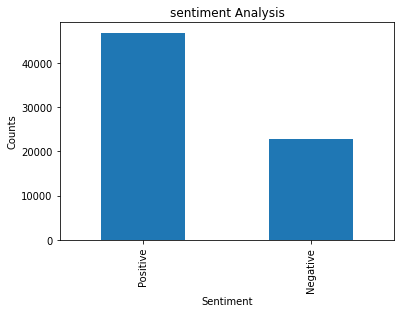

In [ ]:
#Check the Value counts of Positive Negative Tweets
df3['Analysis'].value_counts()

plt.title("sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
df3['Analysis'].value_counts().plot(kind='bar')
plt.show()

# Load the Processed file for a new session

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/18fnoT6bAlwNZdBD6T295hb38ipUUoMTM/view?usp=sharing' #the shareable link

In [ ]:
id = '18fnoT6bAlwNZdBD6T295hb38ipUUoMTM'

print (id) # Verify that you have everything after '='

18fnoT6bAlwNZdBD6T295hb38ipUUoMTM


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('covid_vaccine_tagged_bi.csv')  
df3 = pd.read_csv('covid_vaccine_tagged_bi.csv')

In [ ]:
df3 = pd.read_csv('/content/covid_vaccine_tagged_bi.csv')

In [ ]:
df3

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
0,1,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405.0,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,folk said daikon paste could treat cytokine st...,0.761312,Positive,-118.231705,34.219170
1,2,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834.0,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,world wrong side history year hopefully bigges...,0.641351,Positive,-122.727652,37.785063
2,3,1.337858e+18,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10.0,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,0.572634,Positive,-2.942752,42.685166
3,4,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165.0,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,fact immutable senator even youre not ethicall...,0.499397,Negative,-123.124101,49.257308
4,5,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152.0,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,explain need vaccine whereareallthesickpeople ...,0.786513,Positive,12.502155,13.187038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48537,48538,1.380593e+18,DV Putnam County,"Putnam County, NY",Daily Voice Putnam County covers our friends a...,2014-06-22 21:38:29,1541.0,89.0,11.0,False,2021-04-09 18:47:46,* COVID-19 * Here's a breakdown of how many ha...,"['Moderna', 'Pfiser', 'COVID19']",SPTK: PutnamDV,0.0,0.0,False,covid19 here breakdown many seen side effect m...,0.864736,Positive,-73.756424,41.423842
48538,48539,1.380593e+18,Daily Voice Suffolk County,NaN,NaN,2019-04-22 15:45:54,227.0,5.0,1.0,False,2021-04-09 18:47:25,* COVID-19 * Here's a breakdown of how many ha...,"['Moderna', 'Pfiser', 'COVID19']",Daily Voice Suffolk County,0.0,0.0,False,covid19 here breakdown many seen side effect m...,0.864736,Positive,12.502155,13.187038
48539,48540,1.380593e+18,Heddar Oussama,NaN,fitness lover \na model \ngym is my life \nan ...,2020-06-26 18:28:29,7.0,75.0,32.0,False,2021-04-09 18:46:03,Time to go hard or go home 😏\n#fitness \n#Advi...,"['fitness', 'AdviceForSuccess', 'Moderna', 'mo...",Twitter for Android,0.0,1.0,False,time go hard go home fitness adviceforsuccess ...,0.470131,Negative,12.502155,13.187038
48540,48541,1.380592e+18,ATLANTA NIGHTLIFE,"Georgia, USA",Just a Twitter account primarly to post inform...,2009-02-17 02:49:51,4328.0,4899.0,1380.0,False,2021-04-09 18:42:38,#atlchat\n\nI just received my second shot of ...,"['atlchat', 'Moderna', 'quarantine']",Twitter for Android,0.0,0.0,False,atlchat received second shot moderna quarantin...,0.859608,Positive,-83.178335,32.678559


In [ ]:
df3 = df3[df3.Analysis.notna()]

In [ ]:
df3 = df3.reset_index(drop = True)

In [ ]:
df3

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
0,1,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405.0,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,folk said daikon paste could treat cytokine st...,0.761312,Positive,-118.231705,34.219170
1,2,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834.0,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,world wrong side history year hopefully bigges...,0.641351,Positive,-122.727652,37.785063
2,3,1.337858e+18,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10.0,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,coronavirus sputnikv astrazeneca pfizerbiontec...,0.572634,Positive,-2.942752,42.685166
3,4,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165.0,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,fact immutable senator even youre not ethicall...,0.499397,Negative,-123.124101,49.257308
4,5,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152.0,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,explain need vaccine whereareallthesickpeople ...,0.786513,Positive,12.502155,13.187038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69718,69719,1.382248e+18,Russian Mission in Geneva,Geneve,Постпредство России при Отделении ООН и др. ме...,2011-07-26 08:40:47,9862.0,589.0,3502.0,True,2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,['Gamaleya'],Twitter for iPhone,2.0,9.0,False,🇷🇺gamaleya research center cooperation 🇮🇹 spal...,0.609648,Positive,6.143047,46.204829
69719,69720,1.382246e+18,Mora Mosese,NtswanaTsatsi,#MoAfrika - #MoSotho,2019-12-06 11:11:07,164.0,101.0,6465.0,False,2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,"['SputnikV', 'AfricanExpertise', 'ShamDemic']",Twitter Web App,0.0,0.0,False,sputnikv africanexpertise medical academic voi...,0.502593,Positive,28.855412,-27.228607
69720,69721,1.382245e+18,Robert ka Boss,NaN,Lily don't be silly you want to know me just g...,2020-11-26 09:24:12,76.0,65.0,78.0,False,2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",NaN,Twitter Web App,0.0,0.0,False,hello stubbornness foolishness facing second w...,0.956859,Positive,12.502155,13.187038
69721,69722,1.382243e+18,Mick Brown,"Cambridge, UK","Retired 1960s dropout, part-time self-appointe...",2011-12-05 14:11:05,1882.0,1850.0,83008.0,False,2021-04-14 08:04:35,In a lengthy interview on #wato some months ag...,"['wato', 'SputnikV']",Twitter for Android,0.0,0.0,False,lengthy interview wato month ago representativ...,0.915655,Positive,0.126595,52.197586


# Model Evaluation

In [ ]:
data = df3

In [ ]:

X = data['Clean_text'].values
y = data['Analysis'].values



In [ ]:
print(X.shape)
print(y.shape)

(69714,)
(69714,)


**Convert text to word frequency vectors**

In [ ]:

#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))



Vector fitted.
No. of feature_words:  42252


In [ ]:
print(X.shape)
print(y.shape)

(69714, 42252)
(69714,)


**Split and Train Test**



The Preprocessed Data is divided into 2 sets of data:


*   Training Data: The dataset upon which the model would be trained on. Contains 80% data.
*  Test Data: The dataset upon which the model would be tested against. Contains 20% data.








In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (55771, 42252)
y_train (55771,)

X_test (13943, 42252)
y_test (13943,)


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

NameError: ignored





# Data Visualization

In [ ]:
#Create instances of positive and negative dataframes
df_positive = df3.loc[df3['Analysis'] == 'Positive']
df_negative = df3.loc[df3['Analysis'] == 'Negative']

In [ ]:
#converting pandas object to a string type
df3['processed_tweets'] = df3['processed_tweets'].astype('str')

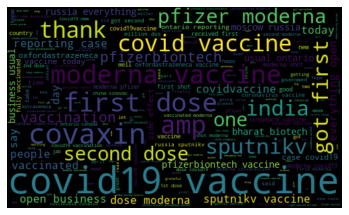

In [ ]:
#Plot the Word Cloud For Positive Tweets
allWords = ' '.join( [twts for twts in df_positive['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

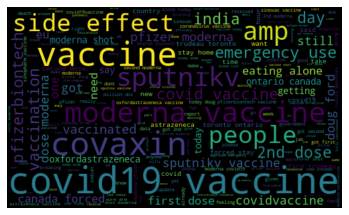

In [ ]:
#Plot the Word Cloud For Negative Tweets
allWords = ' '.join( [twts for twts in df_negative['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

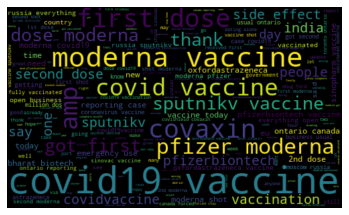

In [ ]:
#Plot the Word Cloud For All tweets Tweets
allWords = ' '.join( [twts for twts in df3['processed_tweets']])
wordCloud = WordCloud(width= 500, height=300, random_state= 21, max_font_size= 119).generate(allWords)

plt.imshow(wordCloud, interpolation=  "bilinear")
plt.axis('off')
plt.show()

   Analysis  tweets
0  Negative   24869
1  Positive   44845


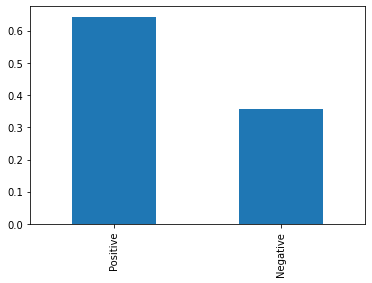

In [ ]:
# Plot sentiment value counts
import plotly.express as px
import matplotlib.pyplot as plt
df3['Analysis'].value_counts(normalize=True).plot.bar();

timeline = df3.groupby(['Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='Analysis', y="tweets", color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [ ]:
# Convert dates
df3['date'] = pd.to_datetime(df3['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = df3.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA"], category_orders={'sentiment': ['negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    #df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='Analysis',  color_discrete_sequence=["#636EFA","#EF553B" ], category_orders={'Analysis': ['negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(df3, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(df3, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(df3, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(df3, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(df3, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(df3, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(df3, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['Analysis'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative','Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

# Event Detection


In [ ]:
#converting pandas object to a string type
data['text'] = data['text'].astype('str')

NameError: ignored

In [ ]:
Event_data = df3

#converting pandas object to a string type
Event_data['user_favourites'] = Event_data['user_favourites'].astype('int')
Event_data['user_followers'] = Event_data['user_followers'].astype('int')
Event_data['user_friends'] = Event_data['user_friends'].astype('int')

Event_data = Event_data.loc[(Event_data['user_favourites'] > 10000) & (Event_data['user_followers'] > 10000)]

In [ ]:
Event_data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Clean_text,Tweet_tokenized,Tweet_nonstop,Tweet_lemma,Polarity,Analysis
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,49165,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,facts are immutable senator even when youre no...,"['facts', 'are', 'immutable', 'senator', 'even...","['facts', 'immutable', 'senator', 'even', 'you...","['fact', 'immutable', 'senator', 'even', 'your...",0.429918,Negative
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,21924,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,there have not been many bright days in but h...,"['there', 'have', 'not', 'been', 'many', 'brig...","['not', 'many', 'bright', 'days', 'best', 'bid...","['not', 'many', 'bright', 'day', 'best', 'bide...",0.386054,Negative
12,1337815730486702087,WION,India,#WION: World Is One | Welcome to India’s first...,2016-03-21 03:44:54,292510,91,292510,True,2020-12-12 17:45:00,The agency also released new information for h...,NaN,TweetDeck,0,18,False,the agency also released new information for h...,"['the', 'agency', 'also', 'released', 'new', '...","['agency', 'also', 'released', 'new', 'informa...","['agency', 'also', 'released', 'new', 'informa...",0.837633,Positive
13,1337809196453081088,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,21924,True,2020-12-12 17:19:02,For all the women and healthcare providers who...,['PfizerBioNTech'],Twitter for iPhone,48,82,False,for all the women and healthcare providers who...,"['for', 'all', 'the', 'women', 'and', 'healthc...","['women', 'healthcare', 'providers', 'asking',...","['woman', 'healthcare', 'provider', 'asking', ...",0.763494,Positive
14,1337807109010780162,Opoyi,NaN,High-quality trusted conversations around news...,2019-01-13 18:33:22,10332,49,10332,False,2020-12-12 17:10:44,"""Expect 145 sites across all the states to rec...",NaN,TweetDeck,0,0,False,expect sites across all the states to receive...,"['expect', 'sites', 'across', 'all', 'the', 's...","['expect', 'sites', 'across', 'states', 'recei...","['expect', 'site', 'across', 'state', 'receive...",0.607818,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69696,1382257587656171521,ET NOW,India,Youtube: https://t.co/u54RR8zcQ8 Facebook: htt...,2010-12-10 12:49:29,641608,79,641608,True,2021-04-14 09:01:04,#SputnikV will initially be imported from #Rus...,"['SputnikV', 'Russia']",Twitter Web App,2,36,False,sputnikv will initially be imported from russi...,"['sputnikv', 'will', 'initially', 'be', 'impor...","['sputnikv', 'initially', 'imported', 'russia'...","['sputnikv', 'initially', 'imported', 'russia'...",0.545916,Positive
69699,1382255193832661000,ET NOW,India,Youtube: https://t.co/u54RR8zcQ8 Facebook: htt...,2010-12-10 12:49:29,641608,79,641608,True,2021-04-14 08:51:33,#BREAKING | We don't expect to seek funding . ...,"['BREAKING', 'SputnikV']",Twitter Web App,0,9,False,breaking we dont expect to seek funding dont...,"['breaking', 'we', 'dont', 'expect', 'to', 'se...","['breaking', 'dont', 'expect', 'seek', 'fundin...","['breaking', 'dont', 'expect', 'seek', 'fundin...",0.089976,Negative
69706,1382251000321298432,CNBC-TV18,NaN,Follow business news with India's Leading Busi...,2012-07-10 08:32:06,901778,213,901778,True,2021-04-14 08:34:54,#IndiaFightsCorona | After govt's approval for...,['IndiaFightsCorona'],Periscope,3,3,False,indiafightscorona after govts approval for em...,"['indiafightscorona', 'after', 'govts', 'appro...","['indiaf

In [ ]:
# Plot sentiment value counts
import plotly.express as px
import matplotlib.pyplot as plt
Event_data['Analysis'].value_counts(normalize=True).plot.bar();

timeline = Event_data.groupby(['Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='Analysis', y="tweets", color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

NameError: ignored

In [ ]:
# Convert dates
Event_data['date'] = pd.to_datetime(Event_data['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = Event_data.groupby(['date', 'Analysis']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='Analysis', color_discrete_sequence=["#EF553B", "#636EFA"], category_orders={'Analysis': ['Negative', 'Positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
# Function to filter the data to a single date and print tweets from users with the most followers
Event_data_date = Event_data
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'Clean_text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(Event_data, ['2021-03-01', '2021-03-03','2021-04-08','2021-04-21'])

,date,Clean_text
15275,2021-03-01,pm has always led from the front in encouragin...
13162,2021-03-01,always the first to lead from the front we are...
13246,2021-03-01,prime minister of india takes made in india co...
13101,2021-03-01,aiims nurse who gave the covaxin jab to prime ...
17527,2021-03-01,pm takes first dose of covid vaccine covaxin a...
18204,2021-03-01,poll now that there are options of the covid...
18778,2021-03-01,are there no parallel phase trials on for cov...
13354,2021-03-01,pm ‘s vaccine jab comes at a time when india i...
18010,2021-03-01,should zimbabweans trust the sinopharm vaccine...
18009,2021-03-01,as committee on health when are you going to d...


,date,Clean_text
20411,2021-03-03,for those like me who were concerned that cova...
20698,2021-03-03,a great win for atmanirbhar bharat india’s ind...
20924,2021-03-03,phase results of covaxin announced by demon...
20925,2021-03-03,breaking bharat biotech says its covaxin show...
20913,2021-03-03,clinical efficacy of indiamade covaxin is say...
20745,2021-03-03,phase clinical trial of covaxin developed by ...
19132,2021-03-03,carrie lam demoed vigorously that seniors can ...
20723,2021-03-03,afaik covaxin is only in hospitals that have ...
19237,2021-03-03,i love dollyparton and i dont even like countr...
20183,2021-03-03,this is the definition of acute stockholm synd...


,date,Clean_text
55079,2021-04-08,has anyone seen the phase data on covaxin wh...
55283,2021-04-08,i asked on why were we being denied vaccines w...
55018,2021-04-08,i am again now live on pleading the honble pm ...
49159,2021-04-08,he tried to control it like he tries control ...
49316,2021-04-08,we are begging for more vaccine with folded h...
55197,2021-04-08,covaxin first dose taken come on india get vac...
49035,2021-04-08,the covid vaccines from pfizer moderna and joh...
54900,2021-04-08,classic chameleonthis👇 chattisgarh has seen ra...
49156,2021-04-08,an after effect of the moderna covid vaccine t...
50430,2021-04-08,got my first does of sputnikv covid vaccinatio...


,date,Clean_text
66439,2021-04-21,great news bharat biotech covaxin announcement...
66818,2021-04-21,icmr study shows covaxin neutralises against m...
65683,2021-04-21,india of those vaccinated with covaxin tested...
65859,2021-04-21,ok we need more clarity on this covaxin vaccine
65543,2021-04-21,my debate on todaywhere i call out hypocrisy o...
65463,2021-04-21,from shashi tharoor to manish tewari ampofcour...
62057,2021-04-21,initial health checkin vsafe cdc enter info ab...
66495,2021-04-21,covaxin neutralises multiple variants of coron...
65736,2021-04-21,just out of k people who were administered bo...
66607,2021-04-21,study shows covaxin neutralises against multi...


# Select 100 random Tweets


In [ ]:
#Random_100=np.random.choice(df3, 100)
Random_100=df3.sample(100)
Random_100

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat
49370,49371,1.380011e+18,Kumauni,"New Delhi, Uttarakhand India","Uttarakhand, Delhi, India.",2012-06-20 19:56:17,7627.0,1149.0,8952.0,False,2021-04-08 04:14:25,If BJP can't manage Covid vaccine management p...,NaN,Twitter Web App,31.0,36.0,False,bjp cant manage covid vaccine management prope...,0.348898,Negative,77.190346,28.583387
62859,62860,1.384501e+18,#VishalThakkar®🇮🇳,Global,Nationalist | News Savvy | Fact Reader | Data ...,2011-08-03 07:44:48,233.0,411.0,388.0,False,2021-04-20 13:37:24,Companies like #Pfizer and #Moderna refuse to ...,"['Pfizer', 'Moderna']",Twitter for Android,0.0,0.0,False,company like pfizer moderna refuse test safety...,0.804106,Positive,-79.348975,43.728619
897,898,1.339939e+18,DT Next,"Chennai, India",English language newspaper by the Daily Thanth...,2015-10-23 12:33:47,6859.0,418.0,148.0,True,2020-12-18 14:20:22,US Vice President @Mike_Pence and his wife @Ka...,NaN,TweetDeck,0.0,0.0,False,u vice president wife received shot friday mor...,0.720105,Positive,80.236543,13.043568
29631,29632,1.371502e+18,Bring 🇨🇦 Troops Home!,NaN,🇨🇦doesn't need to be in 🇮🇱 Wars!,2013-12-28 13:09:55,926.0,235.0,6475.0,False,2021-03-15 16:40:30,@kady @LeonaAlleslev @lraitt @DavidLametti @CT...,NaN,Twitter Web App,0.0,0.0,False,nan,0.586637,Positive,12.502155,13.187038
56394,56395,1.381622e+18,𝐂𝐀𝐏𝐓𝐈𝐕𝐀𝐓𝐄𝐃 𝐁𝐘 𝐘𝐎𝐔 ⚡💫,EXO Planet,𝓢𝓱𝓪𝓵𝓵 𝓦𝓮 𝓬𝓻𝓸𝓼𝓼 𝓽𝓱𝓮 𝓼𝓹𝓪𝓻𝓴𝓵𝓲𝓷𝓰 𝓰𝓪𝓵𝓪𝔁𝔂 𝓽𝓸𝓰𝓮𝓽𝓱𝓮𝓻? ...,2017-09-10 16:12:20,113.0,501.0,30054.0,False,2021-04-12 14:55:17,So thankful and blessed to be part of History....,NaN,Twitter Web App,0.0,0.0,False,thankful blessed part history got 2nd dose sin...,0.825490,Positive,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48520,48521,1.380602e+18,Carole Ferguson,Calif,"Lover of big books, big music, big hair, big i...",2018-03-30 21:13:19,151.0,1184.0,1693.0,False,2021-04-09 19:23:02,"Dang, this #Moderna shot is trippy.",['Moderna'],Twitter for iPhone,0.0,0.0,False,dang moderna shot trippy,0.182329,Negative,-119.306392,37.269511
59286,59287,1.382893e+18,NTD News,"New York, NY",Your independent voice in TV news—bringing bac...,2018-11-08 16:41:42,69795.0,34.0,1089.0,False,2021-04-16 03:05:01,"“I anticipate in the next year or so, we’re go...",NaN,Buffer,12.0,5.0,False,anticipate next year going see lot variant ceo...,0.772809,Positive,-73.979635,40.696789
33493,33494,1.372882e+18,Mark”Charlie”Philpott,"Falmouth, England",West Ham fan since 1975 All opinions are my own.,2012-08-16 21:07:33,469.0,1035.0,2852.0,False,2021-03-19 12:05:35,Just had my #OxfordAstraZeneca jab. So far so ...,"['OxfordAstraZeneca', 'therealheroes', 'volunt...",Twitter for iPhone,0.0,3.0,False,oxfordastrazeneca jab far good thank therealhe...,0.991370,Positive,-5.068826,50.155220
38646,38647,1.375565e+18,The Win Ott 🇺🇸,"South Carolina, USA","Naturalist, photographer, anti-fascist, actor,...",2016-08-15 23:47:17,276.0,543.0,51173.0,False,2021-03-26 21:47:03,Aw yeah... I gots all my shots!\n#PfizerBioNTe...,"['PfizerBioNTech', 'vaccinated', 'TenFeetTallA...",Twitter for iPhone,0.0,8.0,False,aw yeah gots shot pfizerbiontech vaccinated te...,0.334594,Negative,-80.947676,33.624470


In [ ]:
Random_100.to_csv("100_test.csv")

In [ ]:
true_sentiment = pd.read_csv("/content/true_sentiment.csv")
true_sentiment["100_test"][0]

'True Sentiment'

In [ ]:
#converting pandas object to a string type
true_sentiment['100_test'] = true_sentiment['100_test'].astype('str')

In [ ]:
Random_100 = Random_100.reset_index(drop = True)

In [ ]:
Random_100

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat,True Sentiment
0,49371,1.380011e+18,Kumauni,"New Delhi, Uttarakhand India","Uttarakhand, Delhi, India.",2012-06-20 19:56:17,7627.0,1149.0,8952.0,False,2021-04-08 04:14:25,If BJP can't manage Covid vaccine management p...,NaN,Twitter Web App,31.0,36.0,False,bjp cant manage covid vaccine management prope...,0.348898,Negative,77.190346,28.583387,NaN
1,62860,1.384501e+18,#VishalThakkar®🇮🇳,Global,Nationalist | News Savvy | Fact Reader | Data ...,2011-08-03 07:44:48,233.0,411.0,388.0,False,2021-04-20 13:37:24,Companies like #Pfizer and #Moderna refuse to ...,"['Pfizer', 'Moderna']",Twitter for Android,0.0,0.0,False,company like pfizer moderna refuse test safety...,0.804106,Positive,-79.348975,43.728619,NaN
2,898,1.339939e+18,DT Next,"Chennai, India",English language newspaper by the Daily Thanth...,2015-10-23 12:33:47,6859.0,418.0,148.0,True,2020-12-18 14:20:22,US Vice President @Mike_Pence and his wife @Ka...,NaN,TweetDeck,0.0,0.0,False,u vice president wife received shot friday mor...,0.720105,Positive,80.236543,13.043568,NaN
3,29632,1.371502e+18,Bring 🇨🇦 Troops Home!,NaN,🇨🇦doesn't need to be in 🇮🇱 Wars!,2013-12-28 13:09:55,926.0,235.0,6475.0,False,2021-03-15 16:40:30,@kady @LeonaAlleslev @lraitt @DavidLametti @CT...,NaN,Twitter Web App,0.0,0.0,False,nan,0.586637,Positive,12.502155,13.187038,NaN
4,56395,1.381622e+18,𝐂𝐀𝐏𝐓𝐈𝐕𝐀𝐓𝐄𝐃 𝐁𝐘 𝐘𝐎𝐔 ⚡💫,EXO Planet,𝓢𝓱𝓪𝓵𝓵 𝓦𝓮 𝓬𝓻𝓸𝓼𝓼 𝓽𝓱𝓮 𝓼𝓹𝓪𝓻𝓴𝓵𝓲𝓷𝓰 𝓰𝓪𝓵𝓪𝔁𝔂 𝓽𝓸𝓰𝓮𝓽𝓱𝓮𝓻? ...,2017-09-10 16:12:20,113.0,501.0,30054.0,False,2021-04-12 14:55:17,So thankful and blessed to be part of History....,NaN,Twitter Web App,0.0,0.0,False,thankful blessed part history got 2nd dose sin...,0.825490,Positive,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,48521,1.380602e+18,Carole Ferguson,Calif,"Lover of big books, big music, big hair, big i...",2018-03-30 21:13:19,151.0,1184.0,1693.0,False,2021-04-09 19:23:02,"Dang, this #Moderna shot is trippy.",['Moderna'],Twitter for iPhone,0.0,0.0,False,dang moderna shot trippy,0.182329,Negative,-119.306392,37.269511,NaN
96,59287,1.382893e+18,NTD News,"New York, NY",Your independent voice in TV news—bringing bac...,2018-11-08 16:41:42,69795.0,34.0,1089.0,False,2021-04-16 03:05:01,"“I anticipate in the next year or so, we’re go...",NaN,Buffer,12.0,5.0,False,anticipate next year going see lot variant ceo...,0.772809,Positive,-73.979635,40.696789,NaN
97,33494,1.372882e+18,Mark”Charlie”Philpott,"Falmouth, England",West Ham fan since 1975 All opinions are my own.,2012-08-16 21:07:33,469.0,1035.0,2852.0,False,2021-03-19 12:05:35,Just had my #OxfordAstraZeneca jab. So far so ...,"['OxfordAstraZeneca', 'therealheroes', 'volunt...",Twitter for iPhone,0.0,3.0,False,oxfordastrazeneca jab far good thank therealhe...,0.991370,Positive,-5.068826,50.155220,NaN
98,38647,1.375565e+18,The Win Ott 🇺🇸,"South Carolina, USA","Naturalist, photographer, anti-fascist, actor,...",2016-08-15 23:47:17,276.0,543.0,51173.0,False,2021-03-26 21:47:03,Aw yeah... I gots all my shots!\n#PfizerBioNTe...,"['PfizerBioNTech', 'vaccinated', 'TenFeetTallA...",Twitter for iPhone,0.0,8.0,False,aw yeah gots shot pfizerbiontech vaccinated te...,0.334594,Negative,-80.947676,33.624470,NaN


In [ ]:
true_sentiment = true_sentiment["100_test"][1:]


In [ ]:
true_sentiment = true_sentiment.reset_index(drop = True)
true_sentiment

0     Negative
1     Positive
2     Positive
3          NaN
4     Positive
        ...   
95    Negative
96    Positive
97    Positive
98    Positive
99    Positive
Name: 100_test, Length: 100, dtype: object

In [ ]:
Random_100["True Sentiment"] = true_sentiment
Metric_test = Random_100
Metric_test

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,processed_tweets,Polarity,Analysis,long,lat,True Sentiment
0,49371,1.380011e+18,Kumauni,"New Delhi, Uttarakhand India","Uttarakhand, Delhi, India.",2012-06-20 19:56:17,7627.0,1149.0,8952.0,False,2021-04-08 04:14:25,If BJP can't manage Covid vaccine management p...,NaN,Twitter Web App,31.0,36.0,False,bjp cant manage covid vaccine management prope...,0.348898,Negative,77.190346,28.583387,Negative
1,62860,1.384501e+18,#VishalThakkar®🇮🇳,Global,Nationalist | News Savvy | Fact Reader | Data ...,2011-08-03 07:44:48,233.0,411.0,388.0,False,2021-04-20 13:37:24,Companies like #Pfizer and #Moderna refuse to ...,"['Pfizer', 'Moderna']",Twitter for Android,0.0,0.0,False,company like pfizer moderna refuse test safety...,0.804106,Positive,-79.348975,43.728619,Positive
2,898,1.339939e+18,DT Next,"Chennai, India",English language newspaper by the Daily Thanth...,2015-10-23 12:33:47,6859.0,418.0,148.0,True,2020-12-18 14:20:22,US Vice President @Mike_Pence and his wife @Ka...,NaN,TweetDeck,0.0,0.0,False,u vice president wife received shot friday mor...,0.720105,Positive,80.236543,13.043568,Positive
3,29632,1.371502e+18,Bring 🇨🇦 Troops Home!,NaN,🇨🇦doesn't need to be in 🇮🇱 Wars!,2013-12-28 13:09:55,926.0,235.0,6475.0,False,2021-03-15 16:40:30,@kady @LeonaAlleslev @lraitt @DavidLametti @CT...,NaN,Twitter Web App,0.0,0.0,False,nan,0.586637,Positive,12.502155,13.187038,NaN
4,56395,1.381622e+18,𝐂𝐀𝐏𝐓𝐈𝐕𝐀𝐓𝐄𝐃 𝐁𝐘 𝐘𝐎𝐔 ⚡💫,EXO Planet,𝓢𝓱𝓪𝓵𝓵 𝓦𝓮 𝓬𝓻𝓸𝓼𝓼 𝓽𝓱𝓮 𝓼𝓹𝓪𝓻𝓴𝓵𝓲𝓷𝓰 𝓰𝓪𝓵𝓪𝔁𝔂 𝓽𝓸𝓰𝓮𝓽𝓱𝓮𝓻? ...,2017-09-10 16:12:20,113.0,501.0,30054.0,False,2021-04-12 14:55:17,So thankful and blessed to be part of History....,NaN,Twitter Web App,0.0,0.0,False,thankful blessed part history got 2nd dose sin...,0.825490,Positive,NaN,NaN,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,48521,1.380602e+18,Carole Ferguson,Calif,"Lover of big books, big music, big hair, big i...",2018-03-30 21:13:19,151.0,1184.0,1693.0,False,2021-04-09 19:23:02,"Dang, this #Moderna shot is trippy.",['Moderna'],Twitter for iPhone,0.0,0.0,False,dang moderna shot trippy,0.182329,Negative,-119.306392,37.269511,Negative
96,59287,1.382893e+18,NTD News,"New York, NY",Your independent voice in TV news—bringing bac...,2018-11-08 16:41:42,69795.0,34.0,1089.0,False,2021-04-16 03:05:01,"“I anticipate in the next year or so, we’re go...",NaN,Buffer,12.0,5.0,False,anticipate next year going see lot variant ceo...,0.772809,Positive,-73.979635,40.696789,Positive
97,33494,1.372882e+18,Mark”Charlie”Philpott,"Falmouth, England",West Ham fan since 1975 All opinions are my own.,2012-08-16 21:07:33,469.0,1035.0,2852.0,False,2021-03-19 12:05:35,Just had my #OxfordAstraZeneca jab. So far so ...,"['OxfordAstraZeneca', 'therealheroes', 'volunt...",Twitter for iPhone,0.0,3.0,False,oxfordastrazeneca jab far good thank therealhe...,0.991370,Positive,-5.068826,50.155220,Positive
98,38647,1.375565e+18,The Win Ott 🇺🇸,"South Carolina, USA","Naturalist, photographer, anti-fascist, actor,...",2016-08-15 23:47:17,276.0,543.0,51173.0,False,2021-03-26 21:47:03,Aw yeah... I gots all my shots!\n#PfizerBioNTe...,"['PfizerBioNTech', 'vaccinated', 'TenFeetTallA...",Twitter for iPhone,0.0,8.0,False,aw yeah gots shot pfizerbiontech vaccinated te...,0.334594,Negative,-80.947676,33.624470,Positive


In [ ]:
Metric_test.drop(['id','user_name','user_location','user_description','user_created', 'user_followers', 'user_friends'], axis=1, inplace=True)


In [ ]:
Metric_test.drop(['user_favourites', 'user_verified','date','text','hashtags','source','retweets','favorites'
,'is_retweet','Polarity','long','lat'], axis=1, inplace=True)


In [ ]:
Metric_test

,Unnamed: 0,processed_tweets,Analysis,True Sentiment
0,49371,bjp cant manage covid vaccine management prope...,Negative,Negative
1,62860,company like pfizer moderna refuse test safety...,Positive,Positive
2,898,u vice president wife received shot friday mor...,Positive,Positive
3,29632,nan,Positive,NaN
4,56395,thankful blessed part history got 2nd dose sin...,Positive,Positive
...,...,...,...,...
95,48521,dang moderna shot trippy,Negative,Negative
96,59287,anticipate next year going see lot variant ceo...,Positive,Positive
97,33494,oxfordastrazeneca jab far good thank therealhe...,Positive,Positive
98,38647,aw yeah gots shot pfizerbiontech vaccinated te...,Negative,Positive


In [ ]:
Metric_test.to_csv("Metric_test.csv")

# Perform Mertic Evaluations

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for data visualization
%matplotlib inline

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data_metric = pd.read_csv("/content/Metric_test.csv")

In [ ]:
data_metric.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1 , inplace=True )

In [ ]:
#Lets check our shape
data_metric.shape

(100, 3)

In [ ]:
data_metric.head()

,processed_tweets,Analysis,True Sentiment
0,bjp cant manage covid vaccine management prope...,Negative,Negative
1,company like pfizer moderna refuse test safety...,Positive,Positive
2,u vice president wife received shot friday mor...,Positive,Positive
3,NaN,Positive,NaN
4,thankful blessed part history got 2nd dose sin...,Positive,Positive


In [ ]:
data_metric.info

<bound method DataFrame.info of                                      processed_tweets  Analysis True Sentiment
0   bjp cant manage covid vaccine management prope...  Negative       Negative
1   company like pfizer moderna refuse test safety...  Positive       Positive
2   u vice president wife received shot friday mor...  Positive       Positive
3                                                 NaN  Positive            NaN
4   thankful blessed part history got 2nd dose sin...  Positive       Positive
..                                                ...       ...            ...
95                           dang moderna shot trippy  Negative       Negative
96  anticipate next year going see lot variant ceo...  Positive       Positive
97  oxfordastrazeneca jab far good thank therealhe...  Positive       Positive
98  aw yeah gots shot pfizerbiontech vaccinated te...  Negative       Positive
99  southkorea huons global said friday apr 16 lea...  Negative       Positive

[100 rows x 3 colum

In [ ]:
for var in data_metric.columns:
    
    print(data_metric[var].value_counts())

news pfizerbiontech see report                                                                    1
cialaeastereggstravaganza sputnikv nengixitel 방탄소년단 트와이스 카페7드림 nengixitel blessed tweeps choi…    1
vaccine availabilitymy proposal first cater municipal corporation area across india th…           1
president said romania🇷🇴would donate 200000 dos pfizerbiontech covid19 vaccine r…                 1
received first dose moderna covid19 vaccine today ncpa                                            1
                                                                                                 ..
know say wasnt vaccinated ddnt see clearly gave different angle yes vp ch…                        1
congrats‼️🙏 wish best‼️🙏🌴☀️🌈😊 covaxin covaxined                                                   1
sputnikv approved india good goi followed said wondering much lobbyin…                            1
shame covaxin                                                                                     1


Lets change our analysis to integer values for ease of use 

In [ ]:
def sentiment_to_polarity(analysis):
  if analysis == "Positive":
    return 1
  else:
    return 0


In [ ]:
data_metric['Analysis'] = data_metric['Analysis'].apply(sentiment_to_polarity)

In [ ]:
data_metric['True Sentiment'] = data_metric['True Sentiment'].apply(sentiment_to_polarity)

In [ ]:
data_metric.head()

,processed_tweets,Analysis,True Sentiment
0,bjp cant manage covid vaccine management prope...,0,0
1,company like pfizer moderna refuse test safety...,1,1
2,u vice president wife received shot friday mor...,1,1
3,NaN,1,0
4,thankful blessed part history got 2nd dose sin...,1,1


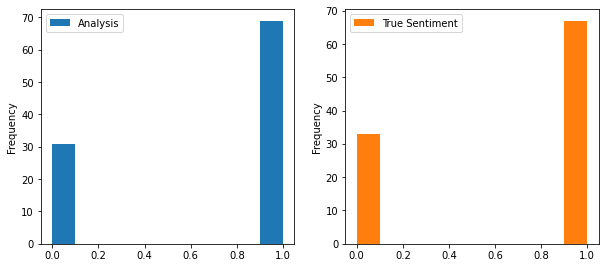

In [ ]:
# plot histograms of the variables


plt.rcParams['figure.figsize']=(10,25)

data_metric.plot(kind='hist', bins=10, subplots=True, layout=(5,2), sharex=False, sharey=False)

plt.show()

Our dataset is very small. So, we can compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes. We can compute it using the data_metric.corr()

In [ ]:
correlation = data_metric.corr()

In [ ]:
correlation['True Sentiment'].sort_values(ascending=False)

True Sentiment    1.000000
Analysis          0.541224
Name: True Sentiment, dtype: float64

We have as expected possitive correlation.

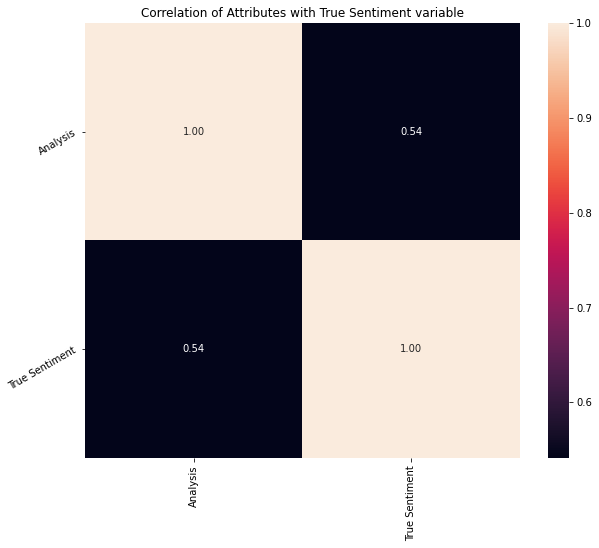

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with True Sentiment variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [ ]:
X = data_metric.drop(['True Sentiment','processed_tweets'], axis=1)

y = data_metric['True Sentiment']

Splitt to train and test dataset

In [ ]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)



In [ ]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((80, 1), (20, 1))

In [ ]:
cols = X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)



In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.head()

,Analysis
0,-1.401058
1,0.713746
2,0.713746
3,-1.401058
4,-1.401058


In [ ]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier


# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3)


# fit the model to the training set
knn.fit(X_train, y_train)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(X_test)

y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#probability for Negative
knn.predict_proba(X_test)[:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.33333333])

In [ ]:
#Probability for Positive
knn.predict_proba(X_test)[:,1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 0.66666667, 1.        ,
       1.        , 1.        , 0.66666667, 1.        , 0.66666667])

Check Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.6500


In [ ]:
y_pred_train = knn.predict(X_train)

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.6750


Check for Overfitting and Underfitting

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

Training set score: 0.6750
Test set score: 0.6500


Pretty Close so no Overfitting

In [ ]:
y_test.value_counts()

1    13
0     7
Name: True Sentiment, dtype: int64

In [ ]:
# check null accuracy score

null_accuracy = (13/(13+20))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.3939


Our test set accuracy us 0.65 and our null accuracy is 0.3939